# Прогноз часового спроса такси по районам — итоговый ноутбук

## Введение
В этом ноутбуке реализую полный конвейер прогнозирования часового спроса такси по районам города:
1. **Загрузка и очистка данных** — объединяем наборы (FHV, Yellow, Green и FHVHV), приводим к единому формату, обрабатываем пропуски и дубликаты.
2. **Исследовательский анализ данных (EDA)** — визуализируем временные ряды, распределения, сезонность, различия между районами.
3. **Feature Engineering** — добавляем временные признаки (час, день недели), бинарный признак праздника.
4. **Baseline-модели** — Naive, Seasonal, MovingAvg, Linear Regression.
5. **LSTM** — прогноз следующего дня для всех районов.
6. **Сравнение результатов** — MAE, RMSE, MAPE, Composite для каждого подхода.

In [1]:
import gdown
import zipfile
import os

file_id = '1sSrnWmisGwuzi8pg704eiJskENzgrGvY'
archive = 'mfdp_data_v1.zip'

gdown.download(id=file_id, output=archive, quiet=False)

with zipfile.ZipFile(archive, 'r') as zip_ref:
    zip_ref.extractall()
for f in os.listdir():
    if f.startswith(archive): os.remove(f)

print('Архив скачан и распакован.')

Downloading...
From (original): https://drive.google.com/uc?id=1sSrnWmisGwuzi8pg704eiJskENzgrGvY
From (redirected): https://drive.google.com/uc?id=1sSrnWmisGwuzi8pg704eiJskENzgrGvY&confirm=t&uuid=06857659-ca17-4c33-81b6-c601b8ed098b
To: C:\Users\Misha\PycharmProjects\mfdp\mfdp_data_v1.zip
100%|██████████| 1.97G/1.97G [02:57<00:00, 11.1MB/s]


Архив скачан и распакован.


Для удобства датасет скачивается с публичного диска как архив. Затем распаковывается в папку mfdp_data, в которой находятся .parquet файлы

In [2]:
import pandas as pd
import glob


files = glob.glob('mfdp_data/*.parquet')
yellow_list = []
green_list = []
fhv_list = []
hvfhv_list = []

for path in files:
    df = pd.read_parquet(path)
    fname = path.lower()

    if 'yellow' in fname and 'tpep_pickup_datetime' in df.columns and 'PULocationID' in df.columns:
        df = df.rename(columns={'tpep_pickup_datetime': 'pickup_datetime', 'PULocationID': 'location_id'})
        df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
        yellow_list.append(df)
    elif 'green' in fname and 'lpep_pickup_datetime' in df.columns and 'PULocationID' in df.columns:
        df = df.rename(columns={'lpep_pickup_datetime': 'pickup_datetime', 'PULocationID': 'location_id'})
        df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
        green_list.append(df)
    elif 'fhvhv' in fname and 'pickup_datetime' in df.columns and 'PULocationID' in df.columns:
        df = df.rename(columns={'PULocationID': 'location_id'})
        df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
        hvfhv_list.append(df)
    elif 'fhv' in fname and 'pickup_datetime' in df.columns and 'PUlocationID' in df.columns:
        df = df.rename(columns={'PUlocationID': 'location_id'})
        df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
        fhv_list.append(df)

yellow_df = pd.concat(yellow_list, ignore_index=True) if yellow_list else pd.DataFrame()
green_df = pd.concat(green_list, ignore_index=True) if green_list else pd.DataFrame()
fhv_df = pd.concat(fhv_list, ignore_index=True) if fhv_list else pd.DataFrame()
hvfhv_df = pd.concat(hvfhv_list, ignore_index=True) if hvfhv_list else pd.DataFrame()

In [3]:
display(yellow_df[(yellow_df['pickup_datetime'] < '2024-01-01') | (yellow_df['pickup_datetime'] > '2025-03-01')])
display(green_df[(green_df['pickup_datetime'] < '2024-01-01') | (green_df['pickup_datetime'] > '2025-03-01')])
display(hvfhv_df[(hvfhv_df['pickup_datetime'] < '2024-01-01') | (hvfhv_df['pickup_datetime'] > '2025-03-01')])

,VendorID,pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,location_id,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
256,2,2023-12-31 23:56:46,2024-01-01 00:12:06,2.0,2.38,1.0,N,236,142,1,15.6,1.00,0.5,1.00,0.00,1.0,21.60,2.5,0.00,NaN
369,2,2023-12-31 23:39:17,2023-12-31 23:42:00,2.0,0.47,1.0,N,90,68,1,5.1,1.00,0.5,0.00,0.00,1.0,10.10,2.5,0.00,NaN
753,2,2023-12-31 23:41:02,2023-12-31 23:48:03,1.0,0.40,1.0,N,246,246,2,7.2,1.00,0.5,0.00,0.00,1.0,12.20,2.5,0.00,NaN
2210,2,2023-12-31 23:57:17,2024-01-01 00:01:50,1.0,0.53,1.0,N,144,211,1,5.8,1.00,0.5,2.16,0.00,1.0,12.96,2.5,0.00,NaN
2615,2,2023-12-31 23:56:45,2024-01-01 00:00:28,1.0,0.97,1.0,N,163,237,1,6.5,1.00,0.5,2.00,0.00,1.0,13.50,2.5,0.00,NaN
2985,2,2023-12-31 23:49:12,2024-01-01 00:04:32,1.0,3.14,1.0,N,234,237,1,17.0,1.00,0.5,6.60,0.00,1.0,28.60,2.5,0.00,NaN
3176,2,2023-12-31 23:47:28,2023-12-31 23:57:07,2.0,1.44,1.0,N,68,137,1,10.7,1.00,0.5,3.14,0.00,1.0,18.84,2.5,0.00,NaN
4137,2,2023-12-31 23:58:35,2024-01-01 00:13:06,6.0,8.39,1.0,N,138,217,2,33.1,6.00,0.5,0.00,0.00,1.0,42.35,0.0,1.75,NaN
4142,2,2023-12-31 23:58:37,2024-01-01 00:08:37,2.0,0.59,1.0,N,161,170,1,10.0,1.00,0.5,3.75,0.00,1.0,18.75,2.5,0.00,NaN
8628,2,2023-12-31 23:54:27,2024-01-01 00:13:12,1.0,7.70,1.0,N,229,244,1,33.1,1.00,0.5,7.62,0.00,1.0,45.72,2.5,0.00,NaN


,VendorID,pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,location_id,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee
90729,2,2025-03-01 00:05:02,2025-03-01 00:11:23,N,1.0,95,95,1.0,1.04,8.6,...,0.5,2.22,0.0,NaN,1.0,13.32,1.0,1.0,0.00,0.00
90730,2,2025-03-01 01:00:17,2025-03-01 01:08:33,N,1.0,95,95,1.0,1.34,10.7,...,0.5,1.80,0.0,NaN,1.0,15.00,1.0,1.0,0.00,0.00
90762,2,2025-03-01 02:04:22,2025-03-01 02:11:33,N,1.0,95,95,1.0,1.18,9.3,...,0.5,3.54,0.0,NaN,1.0,15.34,1.0,1.0,0.00,0.00
90774,2,2025-03-01 02:19:29,2025-03-01 02:25:03,N,1.0,42,159,1.0,1.63,9.3,...,0.5,0.00,0.0,NaN,1.0,11.80,1.0,1.0,0.00,0.00
90785,2,2025-03-01 04:11:13,2025-03-01 04:11:20,N,5.0,74,74,1.0,0.00,25.0,...,0.0,0.00,0.0,NaN,1.0,26.00,1.0,2.0,0.00,0.00
91073,2,2025-03-01 10:28:17,2025-03-01 10:43:42,N,1.0,95,56,1.0,2.02,15.6,...,0.5,1.75,0.0,NaN,1.0,18.85,1.0,1.0,0.00,0.00
91148,2,2025-03-01 11:33:01,2025-03-01 11:40:56,N,1.0,95,95,1.0,0.91,8.6,...,0.5,0.00,0.0,NaN,1.0,10.10,2.0,1.0,0.00,0.00
92229,2,2025-03-01 20:30:40,2025-03-01 20:38:49,N,1.0,74,263,1.0,2.02,11.4,...,0.5,1.00,0.0,NaN,1.0,14.90,1.0,1.0,0.00,0.00
92303,2,2025-03-01 21:34:44,2025-03-01 21:47:53,N,1.0,74,238,1.0,2.69,15.6,...,0.5,0.00,0.0,NaN,1.0,18.10,1.0,1.0,0.00,0.00
92353,2,2025-03-01 22:04:44,2025-03-01 22:14:26,N,1.0,74,41,1.0,1.45,11.4,...,0.5,2.78,0.0,NaN,1.0,16.68,1.0,1.0,0.00,0.00


,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,location_id,DOLocationID,trip_miles,...,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag,cbd_congestion_fee


Отфильтруем лишние даты

In [4]:
yellow_df = yellow_df[(yellow_df['pickup_datetime'] >= '2024-01-01') & 
                     (yellow_df['pickup_datetime'] < '2025-03-01')]
                     
green_df = green_df[(green_df['pickup_datetime'] >= '2024-01-01') & 
                   (green_df['pickup_datetime'] < '2025-03-01')]
                   
hvfhv_df = hvfhv_df[(hvfhv_df['pickup_datetime'] >= '2024-01-01') & 
                   (hvfhv_df['pickup_datetime'] < '2025-03-01')]

In [5]:
from IPython.display import display, Markdown
import pandas as pd

def analyze_dataset(name, df):
    display(Markdown(f'### Анализ набора данных: {name}'))
    display(Markdown(f'**Размерность:** {df.shape[0]} строк × {df.shape[1]} столбцов'))
    
    display(Markdown('#### Общая информация'))
    df.info()
    
    display(Markdown('#### Первые 5 строк'))
    display(df.head())
    
    display(Markdown('#### Пропущенные значения'))
    missing = pd.DataFrame({
        'Количество пропусков': df.isna().sum(),
        'Процент': (df.isna().mean() * 100).round(2)
    })
    display(missing)

    if 'location_id' in df.columns:
        ratio = df['location_id'].isna().mean()
        display(Markdown(f'**Доля пропусков в location_id:** {ratio:.2%}'))
        
        display(Markdown('#### Анализ location_id'))
        loc_stats = pd.Series(dtype='int')
        if df['location_id'].notna().any():
            loc_stats = df['location_id'].value_counts()
            value = df['location_id'].nunique()
            display(Markdown(f'- Уникальных значений: {value}'))
            display(Markdown('**Топ-10 самых популярных локаций:**'))
            display(loc_stats.head(10))
    

    if 'pickup_datetime' in df.columns:
        display(Markdown('#### Топ-10 часов с наибольшим числом поездок'))
        if pd.api.types.is_datetime64_any_dtype(df['pickup_datetime']):
            df['_hour'] = df['pickup_datetime'].dt.hour
            hour_counts = df['_hour'].value_counts().sort_values(ascending=False)
            display(hour_counts.head(10))
            df.drop(columns=['_hour'], inplace=True, errors='ignore')

    display(Markdown('---'))


In [6]:
analyze_dataset('Yellow Taxi', yellow_df)

### Анализ набора данных: Yellow Taxi

**Размерность:** 48222435 строк × 20 столбцов

#### Общая информация

<class 'pandas.core.frame.DataFrame'>
Index: 48222435 entries, 0 to 48222488
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int32         
 1   pickup_datetime        datetime64[us]
 2   tpep_dropoff_datetime  datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   location_id            int32         
 8   DOLocationID           int32         
 9   payment_type           int64         
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  Airport_fee            fl

#### Первые 5 строк

,VendorID,pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,location_id,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0,NaN
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0,NaN
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0,NaN
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0,NaN
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0,NaN


#### Пропущенные значения

,Количество пропусков,Процент
VendorID,0,0.00
pickup_datetime,0,0.00
tpep_dropoff_datetime,0,0.00
passenger_count,5438318,11.28
trip_distance,0,0.00
RatecodeID,5438318,11.28
store_and_fwd_flag,5438318,11.28
location_id,0,0.00
DOLocationID,0,0.00
payment_type,0,0.00


**Доля пропусков в location_id:** 0.00%

#### Анализ location_id

- Уникальных значений: 263

**Топ-10 самых популярных локаций:**

location_id
132    2261586
161    2245993
237    2236434
236    2033635
162    1650497
230    1631514
186    1594676
142    1529634
138    1469974
170    1369487
Name: count, dtype: int64

#### Топ-10 часов с наибольшим числом поездок

_hour
18    3498089
17    3315094
19    3056528
16    2991723
15    2932319
21    2832343
14    2828785
20    2768931
13    2634541
22    2617815
Name: count, dtype: int64

---

In [7]:
analyze_dataset('Green Taxi', green_df)

### Анализ набора данных: Green Taxi

**Размерность:** 94933 строк × 21 столбцов

#### Общая информация

<class 'pandas.core.frame.DataFrame'>
Index: 94933 entries, 0 to 94946
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               94933 non-null  int32         
 1   pickup_datetime        94933 non-null  datetime64[us]
 2   lpep_dropoff_datetime  94933 non-null  datetime64[us]
 3   store_and_fwd_flag     90580 non-null  object        
 4   RatecodeID             90580 non-null  float64       
 5   location_id            94933 non-null  int32         
 6   DOLocationID           94933 non-null  int32         
 7   passenger_count        90580 non-null  float64       
 8   trip_distance          94933 non-null  float64       
 9   fare_amount            94933 non-null  float64       
 10  extra                  94933 non-null  float64       
 11  mta_tax                94933 non-null  float64       
 12  tip_amount             94933 non-null  float64       
 13  tolls_

#### Первые 5 строк

,VendorID,pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,location_id,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,cbd_congestion_fee
0,2,2025-01-01 00:03:01,2025-01-01 00:17:12,N,1.0,75,235,1.0,5.93,24.70,...,0.5,6.80,0.00,NaN,1.0,34.00,1.0,1.0,0.00,0.0
1,2,2025-01-01 00:19:59,2025-01-01 00:25:52,N,1.0,166,75,1.0,1.32,8.60,...,0.5,0.00,0.00,NaN,1.0,11.10,2.0,1.0,0.00,0.0
2,2,2025-01-01 00:05:29,2025-01-01 00:07:21,N,5.0,171,73,1.0,0.41,25.55,...,0.0,0.00,0.00,NaN,1.0,26.55,2.0,2.0,0.00,0.0
3,2,2025-01-01 00:52:24,2025-01-01 01:07:52,N,1.0,74,223,1.0,4.12,21.20,...,0.5,6.13,6.94,NaN,1.0,36.77,1.0,1.0,0.00,0.0
4,2,2025-01-01 00:25:05,2025-01-01 01:01:10,N,1.0,66,158,1.0,4.71,33.80,...,0.5,7.81,0.00,NaN,1.0,46.86,1.0,1.0,2.75,0.0


#### Пропущенные значения

,Количество пропусков,Процент
VendorID,0,0.00
pickup_datetime,0,0.00
lpep_dropoff_datetime,0,0.00
store_and_fwd_flag,4353,4.59
RatecodeID,4353,4.59
location_id,0,0.00
DOLocationID,0,0.00
passenger_count,4353,4.59
trip_distance,0,0.00
fare_amount,0,0.00


**Доля пропусков в location_id:** 0.00%

#### Анализ location_id

- Уникальных значений: 231

**Топ-10 самых популярных локаций:**

location_id
74     22768
75     15791
43      5149
166     4501
95      4294
41      3992
97      3731
82      3504
65      2869
130     2634
Name: count, dtype: int64

#### Топ-10 часов с наибольшим числом поездок

_hour
17    8062
18    7484
16    7473
15    6599
19    5852
14    5842
13    5570
12    5057
9     5028
10    5003
Name: count, dtype: int64

---

In [8]:
analyze_dataset('FHV', fhv_df)

### Анализ набора данных: FHV

**Размерность:** 21107156 строк × 7 столбцов

#### Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21107156 entries, 0 to 21107155
Data columns (total 7 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   dispatching_base_num    object        
 1   pickup_datetime         datetime64[us]
 2   dropOff_datetime        datetime64[us]
 3   location_id             float64       
 4   DOlocationID            float64       
 5   SR_Flag                 float64       
 6   Affiliated_base_number  object        
dtypes: datetime64[us](2), float64(3), object(2)
memory usage: 1.1+ GB


#### Первые 5 строк

,dispatching_base_num,pickup_datetime,dropOff_datetime,location_id,DOlocationID,SR_Flag,Affiliated_base_number
0,B00053,2024-01-01 00:15:00,2024-01-01 02:13:00,NaN,NaN,NaN,B00014
1,B00111,2024-01-01 00:30:00,2024-01-01 02:37:00,NaN,NaN,NaN,B00111
2,B00112,2024-01-01 00:27:24,2024-01-01 01:12:05,NaN,14.0,NaN,B00112
3,B00112,2024-01-01 00:10:09,2024-01-01 00:25:39,NaN,133.0,NaN,B00112
4,B00112,2024-01-01 00:57:07,2024-01-01 01:05:04,NaN,14.0,NaN,B00112


#### Пропущенные значения

,Количество пропусков,Процент
dispatching_base_num,0,0.00
pickup_datetime,0,0.00
dropOff_datetime,0,0.00
location_id,16867704,79.91
DOlocationID,3475719,16.47
SR_Flag,21107156,100.00
Affiliated_base_number,0,0.00


**Доля пропусков в location_id:** 79.91%

#### Анализ location_id

- Уникальных значений: 263

**Топ-10 самых популярных локаций:**

location_id
206.0    100245
221.0     99344
92.0      58378
138.0     58023
129.0     56946
214.0     55879
123.0     54958
7.0       53558
23.0      53145
210.0     52149
Name: count, dtype: int64

#### Топ-10 часов с наибольшим числом поездок

_hour
9     1659288
10    1594512
8     1487103
12    1471234
11    1470112
13    1437010
14    1364874
15    1234706
7     1129352
16    1104770
Name: count, dtype: int64

---

In [9]:
analyze_dataset('High-Volume FHV', hvfhv_df)

### Анализ набора данных: High-Volume FHV

**Размерность:** 39745127 строк × 25 столбцов

#### Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39745127 entries, 0 to 39745126
Data columns (total 25 columns):
 #   Column                Dtype         
---  ------                -----         
 0   hvfhs_license_num     object        
 1   dispatching_base_num  object        
 2   originating_base_num  object        
 3   request_datetime      datetime64[us]
 4   on_scene_datetime     datetime64[us]
 5   pickup_datetime       datetime64[us]
 6   dropoff_datetime      datetime64[us]
 7   location_id           int32         
 8   DOLocationID          int32         
 9   trip_miles            float64       
 10  trip_time             int64         
 11  base_passenger_fare   float64       
 12  tolls                 float64       
 13  bcf                   float64       
 14  sales_tax             float64       
 15  congestion_surcharge  float64       
 16  airport_fee           float64       
 17  tips                  float64       
 18  driver_pay            float64       
 19

#### Первые 5 строк

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,location_id,DOLocationID,trip_miles,...,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag,cbd_congestion_fee
0,HV0003,B03404,B03404,2025-01-01 00:28:07,2025-01-01 00:31:17,2025-01-01 00:33:25,2025-01-01 00:54:24,148,211,1.320,...,2.75,0.0,0.0,15.71,N,N,N,N,N,0.0
1,HV0005,B03406,None,2025-01-01 00:18:33,NaT,2025-01-01 00:29:49,2025-01-01 00:41:52,127,244,3.313,...,0.00,0.0,0.0,23.57,N,N,N,N,N,0.0
2,HV0003,B03404,B03404,2025-01-01 00:28:22,2025-01-01 00:31:52,2025-01-01 00:32:39,2025-01-01 01:20:33,132,181,13.430,...,0.00,2.5,0.0,47.75,N,N,N,N,N,0.0
3,HV0003,B03404,B03404,2025-01-01 00:27:13,2025-01-01 00:33:58,2025-01-01 00:34:55,2025-01-01 00:39:19,76,76,0.820,...,0.00,0.0,0.0,12.20,N,N,N,N,N,0.0
4,HV0003,B03404,B03404,2025-01-01 00:33:29,2025-01-01 00:45:46,2025-01-01 00:46:19,2025-01-01 00:53:56,76,76,1.610,...,0.00,0.0,0.0,17.67,N,N,N,N,N,0.0


#### Пропущенные значения

,Количество пропусков,Процент
hvfhs_license_num,0,0.00
dispatching_base_num,0,0.00
originating_base_num,9941523,25.01
request_datetime,0,0.00
on_scene_datetime,9941523,25.01
pickup_datetime,0,0.00
dropoff_datetime,0,0.00
location_id,0,0.00
DOLocationID,0,0.00
trip_miles,0,0.00


**Доля пропусков в location_id:** 0.00%

#### Анализ location_id

- Уникальных значений: 263

**Топ-10 самых популярных локаций:**

location_id
138    700349
132    683001
61     516062
79     504633
230    475537
161    468250
231    452232
234    434557
37     427973
76     426650
Name: count, dtype: int64

#### Топ-10 часов с наибольшим числом поездок

_hour
18    2454363
17    2347454
19    2339058
20    2168253
8     2118752
16    2086584
21    2073300
15    2010394
22    2003361
14    1963209
Name: count, dtype: int64

---

In [10]:
print('Дубликатов в Yellow:', yellow_df.duplicated().sum())
print('Дубликатов в Green:', green_df.duplicated().sum())
print('Дубликатов в FHV:', fhv_df.duplicated().sum())
print('Дубликатов в High-Volume FHV:', hvfhv_df.duplicated().sum())

Дубликатов в Yellow: 4
Дубликатов в Green: 0
Дубликатов в FHV: 32418
Дубликатов в High-Volume FHV: 0


# Анализ
Судя по информации о четырех датасетах все показали довольно хорошие результаты по содержанию полей важных для анализа, кроме For-Hire Vehicle Trip Records. В нём очень много отсутствующих полей location_id, а также очень много дубликатов. Его не будем использовать в исследовании.
Далее избавимся от дубликатов в yellow_df и произведем объединение в общий датасет и проверим на повторы общий датасет. После чего выберем ключевые поля

In [11]:
yellow_df = yellow_df.drop_duplicates().reset_index(drop=True)
print(f'После удаления дубликатов: {yellow_df.shape[0]} строк')
print('Дубликатов в Yellow:', yellow_df.duplicated().sum())

После удаления дубликатов: 48222431 строк
Дубликатов в Yellow: 0


In [12]:
print('Поля Yellow Taxi:')
print(sorted(yellow_df.columns))
print('\nПоля Green Taxi:')
print(sorted(green_df.columns))
print('\nПоля High-Volume FHV:')
print(sorted(hvfhv_df.columns))

hvfhv_df = hvfhv_df.rename(columns={
    'tips': 'tip_amount',
    'tolls': 'tolls_amount',
    'trip_miles': 'trip_distance',
    'airport_fee': 'Airport_fee',
    'dropoff_datetime': 'tpep_dropoff_datetime'
})


common_cols_all = list(set(yellow_df.columns) & set(green_df.columns) & set(hvfhv_df.columns))
combined_df = pd.concat([
    yellow_df[common_cols_all],
    green_df[common_cols_all],
    hvfhv_df[common_cols_all]
], ignore_index=True)

print(f'Датасет: {combined_df.shape[0]} строк, {combined_df.shape[1]} столбцов')
print('Общие поля:')
print(sorted(common_cols_all))

Поля Yellow Taxi:
['Airport_fee', 'DOLocationID', 'RatecodeID', 'VendorID', 'cbd_congestion_fee', 'congestion_surcharge', 'extra', 'fare_amount', 'improvement_surcharge', 'location_id', 'mta_tax', 'passenger_count', 'payment_type', 'pickup_datetime', 'store_and_fwd_flag', 'tip_amount', 'tolls_amount', 'total_amount', 'tpep_dropoff_datetime', 'trip_distance']

Поля Green Taxi:
['DOLocationID', 'RatecodeID', 'VendorID', 'cbd_congestion_fee', 'congestion_surcharge', 'ehail_fee', 'extra', 'fare_amount', 'improvement_surcharge', 'location_id', 'lpep_dropoff_datetime', 'mta_tax', 'passenger_count', 'payment_type', 'pickup_datetime', 'store_and_fwd_flag', 'tip_amount', 'tolls_amount', 'total_amount', 'trip_distance', 'trip_type']

Поля High-Volume FHV:
['DOLocationID', 'access_a_ride_flag', 'airport_fee', 'base_passenger_fare', 'bcf', 'cbd_congestion_fee', 'congestion_surcharge', 'dispatching_base_num', 'driver_pay', 'dropoff_datetime', 'hvfhs_license_num', 'location_id', 'on_scene_datetime',

In [13]:
analyze_dataset('Объединенный датасет', combined_df)

### Анализ набора данных: Объединенный датасет

**Размерность:** 88062491 строк × 8 столбцов

#### Общая информация

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88062491 entries, 0 to 88062490
Data columns (total 8 columns):
 #   Column                Dtype         
---  ------                -----         
 0   DOLocationID          int32         
 1   tolls_amount          float64       
 2   cbd_congestion_fee    float64       
 3   trip_distance         float64       
 4   congestion_surcharge  float64       
 5   tip_amount            float64       
 6   pickup_datetime       datetime64[us]
 7   location_id           int32         
dtypes: datetime64[us](1), float64(5), int32(2)
memory usage: 4.6 GB


#### Первые 5 строк

,DOLocationID,tolls_amount,cbd_congestion_fee,trip_distance,congestion_surcharge,tip_amount,pickup_datetime,location_id
0,79,0.0,NaN,1.72,2.5,0.00,2024-01-01 00:57:55,186
1,236,0.0,NaN,1.80,2.5,3.75,2024-01-01 00:03:00,140
2,79,0.0,NaN,4.70,2.5,3.00,2024-01-01 00:17:06,236
3,211,0.0,NaN,1.40,2.5,2.00,2024-01-01 00:36:38,79
4,148,0.0,NaN,0.80,2.5,3.20,2024-01-01 00:46:51,211


#### Пропущенные значения

,Количество пропусков,Процент
DOLocationID,0,0.00
tolls_amount,0,0.00
cbd_congestion_fee,41173487,46.75
trip_distance,0,0.00
congestion_surcharge,5442671,6.18
tip_amount,0,0.00
pickup_datetime,0,0.00
location_id,0,0.00


**Доля пропусков в location_id:** 0.00%

#### Анализ location_id

- Уникальных значений: 263

**Топ-10 самых популярных локаций:**

location_id
132    2944628
161    2714248
237    2567968
236    2331377
138    2170355
230    2107053
162    1962068
186    1837908
142    1794372
234    1738529
Name: count, dtype: int64

#### Топ-10 часов с наибольшим числом поездок

_hour
18    5959935
17    5670610
19    5401438
16    5085780
15    4949311
20    4941697
21    4909147
14    4797836
22    4623861
13    4449648
Name: count, dtype: int64

---

In [14]:
print('Дубликатов в Объединенном датасете:', combined_df.duplicated().sum())

Дубликатов в Объединенном датасете: 118984


In [15]:
combined_df = combined_df.drop_duplicates().reset_index(drop=True)
print(f'После удаления дубликатов: {combined_df.shape[0]} строк')
print('Дубликатов в Объединенном датасете:', combined_df.duplicated().sum())

После удаления дубликатов: 87943507 строк
Дубликатов в Объединенном датасете: 0


Сгруппируем строки по часу поездки, дате и локации. Добавим поле количество поездок. Поле является ли дата праздником, а также день недели.

In [16]:
import holidays

df = combined_df.copy(deep=True)
df['pickup_date'] = df['pickup_datetime'].dt.date
df['hour'] = df['pickup_datetime'].dt.hour

df = df.groupby(['pickup_date', 'hour', 'location_id']).size().reset_index(name='rides_per_hour')


non_working_holidays = {
    'New Year\'s Day',
    'Washington\'s Birthday',
    'Christmas Day',
    'Martin Luther King Jr. Day',
    'Thanksgiving Day',
    'Labor Day',
    'Memorial Day',
    'Juneteenth National Independence Day',
    'Independence Day',   
}
us_holidays = holidays.US()

def is_non_working_holiday(date):
    name = us_holidays.get(date)
    return name in non_working_holidays if name else False
df['is_holiday'] = pd.to_datetime(df['pickup_date']).apply(is_non_working_holiday)
df['weekday'] = pd.to_datetime(df['pickup_date']).dt.dayofweek
df['pickup_date'] = pd.to_datetime(df['pickup_date'])
df['datetime'] = df['pickup_date'] + pd.to_timedelta(df['hour'], unit='h')
df.to_csv('dataset.csv', index=False)
df.head().to_csv('dataset_mini.csv', index=False)
display(df.head())
display(df.info())

,pickup_date,hour,location_id,rides_per_hour,is_holiday,weekday,datetime
0,2024-01-01,0,4,25,True,0,2024-01-01
1,2024-01-01,0,7,4,True,0,2024-01-01
2,2024-01-01,0,9,1,True,0,2024-01-01
3,2024-01-01,0,10,6,True,0,2024-01-01
4,2024-01-01,0,12,4,True,0,2024-01-01


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1420367 entries, 0 to 1420366
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   pickup_date     1420367 non-null  datetime64[ns]
 1   hour            1420367 non-null  int32         
 2   location_id     1420367 non-null  int32         
 3   rides_per_hour  1420367 non-null  int64         
 4   is_holiday      1420367 non-null  bool          
 5   weekday         1420367 non-null  int32         
 6   datetime        1420367 non-null  datetime64[ns]
dtypes: bool(1), datetime64[ns](2), int32(3), int64(1)
memory usage: 50.1 MB


None

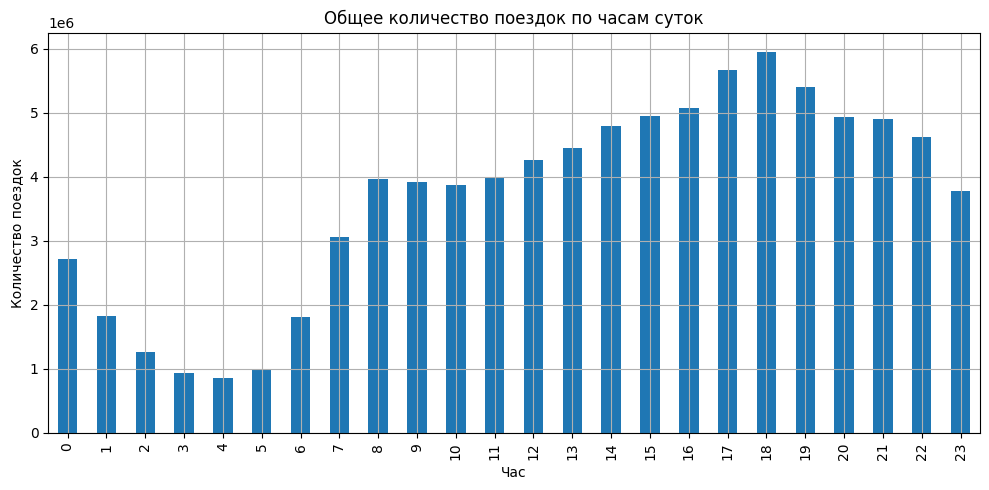

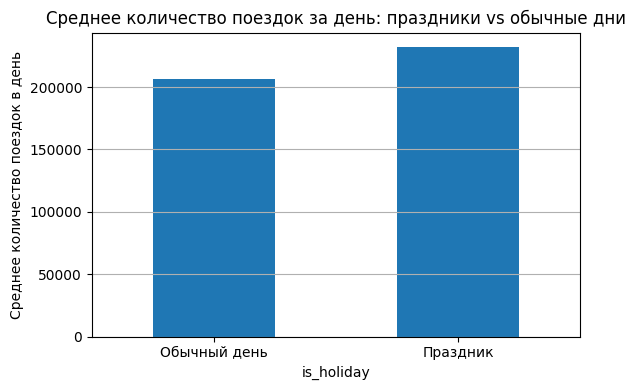

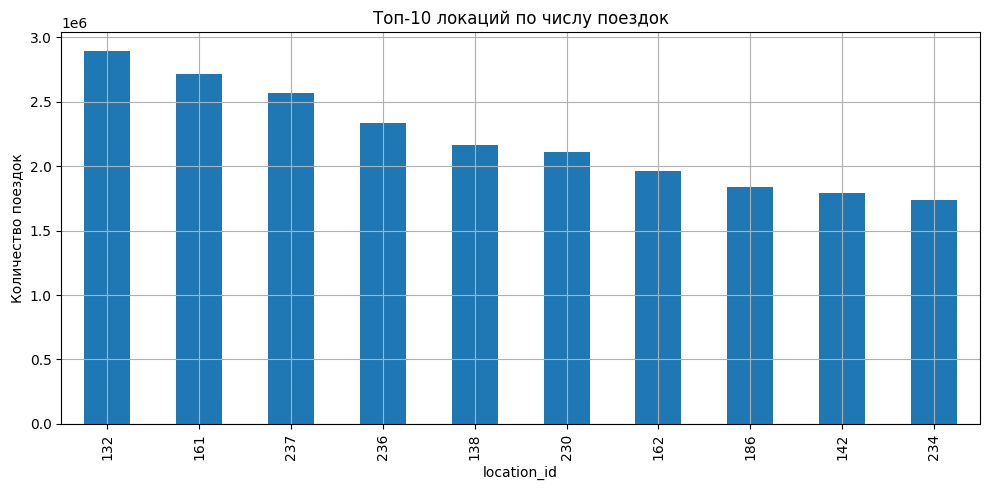

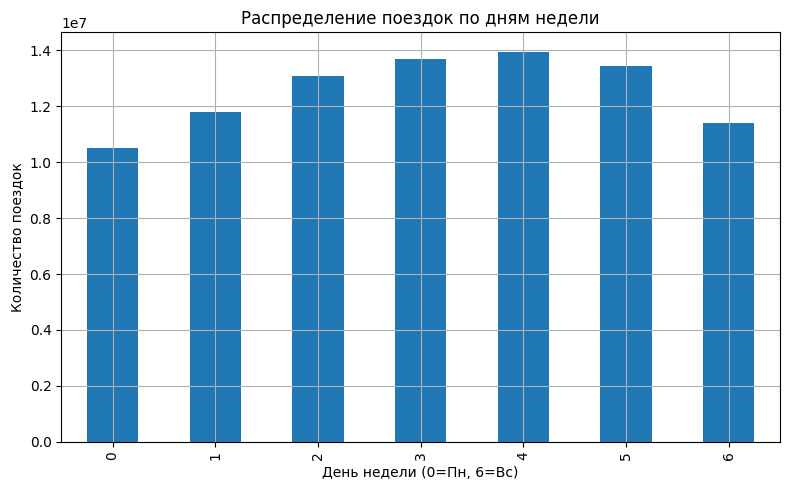

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
df.groupby('hour')['rides_per_hour'].sum().plot(kind='bar')
plt.title('Общее количество поездок по часам суток')
plt.xlabel('Час')
plt.ylabel('Количество поездок')
plt.grid(True)
plt.tight_layout()
plt.show()



plt.figure(figsize=(6, 4))
(
    df.groupby(['pickup_date', 'is_holiday'])['rides_per_hour']
    .sum()
    .groupby('is_holiday')
    .mean()
    .plot(kind='bar')
)
plt.title('Среднее количество поездок за день: праздники vs обычные дни')
plt.xticks([0, 1], ['Обычный день', 'Праздник'], rotation=0)
plt.ylabel('Среднее количество поездок в день')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
df.groupby('location_id')['rides_per_hour'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Топ-10 локаций по числу поездок')
plt.xlabel('location_id')
plt.ylabel('Количество поездок')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
df.groupby('weekday')['rides_per_hour'].sum().plot(kind='bar')
plt.title('Распределение поездок по дням недели')
plt.xlabel('День недели (0=Пн, 6=Вс)')
plt.ylabel('Количество поездок')
plt.grid(True)
plt.tight_layout()
plt.show()

Исходя из графиков видно, что в праздничные дни заказов больше. Больше всего заказов в пт и в 18 часов вечера

In [18]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

from tensorflow import keras
from tensorflow.keras import layers, callbacks, mixed_precision
from tensorflow.keras.optimizers import Adam

mixed_precision.set_global_policy('mixed_float16')

df = pd.read_csv('dataset.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(['location_id', 'datetime']).reset_index(drop=True)

def create_sequences(df, past_steps=72, future_steps=24):
    seqs, tars = [], []
    def cyclic_encode(arr, period):
        sin = np.sin(2*np.pi*arr/period)
        cos = np.cos(2*np.pi*arr/period)
        return np.stack([sin, cos], axis=1)
    
    for loc in df['location_id'].unique():
        sub = df[df['location_id']==loc].sort_values('datetime')
        rides = sub['rides_per_hour'].values
        hours = cyclic_encode(sub['datetime'].dt.hour.values, 24)
        dow   = cyclic_encode(sub['datetime'].dt.dayofweek.values, 7)
        hol   = sub['is_holiday'].astype(int).values.reshape(-1,1)
        
        for i in range(past_steps, len(rides)-future_steps+1):
            window = np.concatenate([
                rides[i-past_steps:i].reshape(-1,1),
                hours[i-past_steps:i],
                dow[i-past_steps:i],
                hol[i-past_steps:i]
            ], axis=1)
            seqs.append(window)
            tars.append(rides[i:i+future_steps].flatten())
    
    return (
        np.array(seqs, dtype='float32'),
        np.array(tars, dtype='float32')
    )

X, y_raw = create_sequences(df)

n = len(X)
cut1, cut2 = int(0.6*n), int(0.8*n)
X_train, X_val,   X_test  = X[:cut1], X[cut1:cut2], X[cut2:]
y_train_raw, y_val_raw, y_test_raw = y_raw[:cut1], y_raw[cut1:cut2], y_raw[cut2:]

target_scaler = StandardScaler().fit(y_train_raw.reshape(-1,1))
y_train = target_scaler.transform(y_train_raw.reshape(-1,1)).reshape(y_train_raw.shape)
y_val   = target_scaler.transform(y_val_raw.reshape(-1,1)).reshape(y_val_raw.shape)
y_test  = y_test_raw

def naive_forecast(X, h=24):
    return np.tile(X[:,-1,0:1], (1,h))

def seasonal_forecast(X, season=72, h=24):
    return np.tile(X[:,-season,0:1], (1,h))

def moving_avg_forecast(X, w=72, h=24):
    ma = np.mean(X[:,-w:,0], axis=1)
    return np.tile(ma.reshape(-1,1),(1,h))

X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat  = X_test.reshape(len(X_test),  -1)
reg = MultiOutputRegressor(LinearRegression())
reg.fit(X_train_flat, y_train_raw)
y_reg = reg.predict(X_test_flat)

def build_lstm_model(input_shape, output_steps):
    inp = keras.Input(shape=input_shape)
    x = layers.LSTM(128, return_sequences=True)(inp)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(64)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(output_steps)(x)
    m = keras.Model(inp, out)
    m.compile(
        optimizer=Adam(1e-4),
        loss='mse',
        metrics=['mae','mape']
    )
    return m

lstm = build_lstm_model(X_train.shape[1:], y_train.shape[1])

es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rl = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=12, batch_size=64,
    callbacks=[es, rl], verbose=1
)

y_lstm_scaled = lstm.predict(X_test)
y_lstm = target_scaler.inverse_transform(
    y_lstm_scaled.reshape(-1,1)
).reshape(y_lstm_scaled.shape)

def evaluate(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred, multioutput='uniform_average')
    comp = (mae + rmse + mape + (1-r2)) / 4
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'R2': r2, 'Composite': comp}

results = {
    'Naive':    evaluate(y_test_raw, naive_forecast(X_test)),
    'Seasonal': evaluate(y_test_raw, seasonal_forecast(X_test)),
    'MovingAvg':evaluate(y_test_raw, moving_avg_forecast(X_test)),
    'LinearReg':evaluate(y_test_raw, y_reg),
    'LSTM':     evaluate(y_test_raw, y_lstm)
}

import pandas as pd
print(pd.DataFrame(results).T.sort_values('MAE'))


Epoch 1/12
13084/13084 ━━━━━━━━━━━━━━━━━━━━ 2073s 158ms/step - loss: 0.2880 - mae: 0.2416 - mape: 116.6941 - val_loss: 0.0766 - val_mae: 0.1195 - val_mape: 66.2161 - learning_rate: 1.0000e-04
Epoch 2/12
13084/13084 ━━━━━━━━━━━━━━━━━━━━ 2467s 189ms/step - loss: 0.1325 - mae: 0.1650 - mape: 88.0926 - val_loss: 0.0673 - val_mae: 0.1117 - val_mape: 62.7192 - learning_rate: 1.0000e-04
Epoch 3/12
13084/13084 ━━━━━━━━━━━━━━━━━━━━ 2530s 193ms/step - loss: 0.1127 - mae: 0.1524 - mape: 82.3293 - val_loss: 0.0603 - val_mae: 0.1058 - val_mape: 57.1274 - learning_rate: 1.0000e-04
Epoch 4/12
13084/13084 ━━━━━━━━━━━━━━━━━━━━ 2424s 185ms/step - loss: 0.1008 - mae: 0.1441 - mape: 78.9587 - val_loss: 0.0588 - val_mae: 0.1048 - val_mape: 58.4786 - learning_rate: 1.0000e-04
Epoch 5/12
13084/13084 ━━━━━━━━━━━━━━━━━━━━ 2501s 191ms/step - loss: 0.0930 - mae: 0.1390 - mape: 76.5099 - val_loss: 0.0584 - val_mae: 0.1039 - val_mape: 59.0927 - learning_rate: 1.0000e-04
Epoch 6/12
13084/13084 ━━━━━━━━━━━━━━━━━━━━ 

## Описание задачи

### Что прогнозирует модель

Модель прогнозирует **почасовой спрос на такси** в каждом районе (`location_id`) на горизонте **24 часа вперёд**, используя исторические данные за **последние 72 часа**.

---

### Используемые дополнительные признаки

Для повышения точности прогноза, помимо нормализованного временного ряда (`rides_per_hour`), добавлены:

- **Циклические признаки**:
  - `sin(hour)`, `cos(hour)` — чтобы учесть суточную периодичность;
  - `sin(day_of_week)`, `cos(day_of_week)` — чтобы уловить недельные шаблоны.
- **Признак праздника** (`is_holiday`) — бинарный флаг для учёта скачков спроса в нерабочие дни.

---

### LSTM модель

- **Архитектура**: два слоя LSTM (`128 → 64` units) + Dropout (0.3 и 0.2) + полносвязные слои.
- **Форма входа**: последовательность длиной 72, где каждый шаг содержит 6 признаков.
- **Форма выхода**: вектор длиной 24 — прогноз на каждый из следующих 24 часов.
- **Функция потерь**: `MSE`.
- **Метрики в обучении**: `MAE`, `MAPE`.

---

### Baseline-модели

| Модель       | Описание                                                        |
|--------------|------------------------------------------------------------------|
| `Naive`      | повторяет последнее наблюдение (`t-1`)                          |
| `Seasonal`   | использует значение из 72 часов назад (`t-72`)                  |
| `MovingAvg`  | среднее по последним 72 часам                                   |
| `LinearReg`  | мультивыходная линейная регрессия по входным признакам окна     |

---

### Выбор и цель метрик

- **MAE** (Mean Absolute Error):  
  Средняя абсолютная ошибка. Простая, интерпретируемая метрика.

- **RMSE** (Root Mean Squared Error):  
  Усиливает вклад больших ошибок, помогает выявить выбросы.

- **MAPE** (Mean Absolute Percentage Error):  
  Относительная ошибка в %. Удобна, когда важно понимать долю ошибки от истинного значения.

- **R²-score** (Коэффициент детерминации):  
  Показывает, насколько модель лучше наивного среднего. Значение от 0 до 1 (чем ближе к 1 — тем лучше).

- **Composite метрика**:  
  Среднее значение по четырём предыдущим метрикам (включая `1 − R²` как штраф за слабое объяснение).  
  Используется как **сводная метрика качества** модели.

---

### Анализ результатов

1. **LSTM**
   - Показала наименьшие ошибки по абсолютным (MAE, RMSE) и относительным (MAPE) метрикам.
   - Высокий R² указывает на то, что сеть объясняет большую часть флуктуаций спроса.
   - Низкая Composite-метрика подтверждает сбалансированное качество прогноза.

2. **Линейная регрессия (LinearReg)**
   - Работает заметно хуже LSTM, но лучше простых базовых стратегий.
   - Относительно высокая R² показывает, что часть сезонных и трэндовых закономерностей модель схватывает.
   - Composite-метрика выше, чем у LSTM, что говорит об ограничениях линейного предположения.

3. **Moving Average**
   - Лучше наивного прогноза, но уступает и LSTM, и регрессии.
   - Средняя прогнозная ошибка в разы больше, чем у LSTM.
   - R² в районе 0.4–0.5 показывает, что метод ловит лишь часть общей динамики.

4. **Наивный прогноз (Naive)**
   - Повтор предыдущего значения даёт слишком грубую оценку: самые высокие MAE/RMSE и MAPE.
   - R² близок к нулю — модель почти не улучшает случайный прогноз.
   - Composite-метрика самая большая, классифицирует прогноз как некорректный.

5. **Seasonal (лаг 3 дня)**
   - Уступает всем остальным: самая большая ошибка и отрицательный R².
   - Метод плохо адаптируется к изменению паттернов, резко отстаёт при пиковых загрузках.

---

- **LSTM** — оптимальный выбор для прогноза почасового спроса: сочетает низкую погрешность и высокую объясняющую способность.
